In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
def analyze_noise_trajectory(S0):
    # System parameters
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    
    # Setup Hamiltonian for optimal frequency calculation
    sc_temp = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    A = 5e-3 * 2 * np.pi
    optimal_omega = sc_temp.optimal_omegad(A)[0]*2*np.pi
    
    # Setup actual system
    sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)
    
    # Setup noise matrix
    noise_matrix = sc.noise.copy()
    first_element = noise_matrix[0, 0]
    for i in range(noise_matrix.shape[0]):
        noise_matrix[i, i] -= first_element
    noise = qt.Qobj(noise_matrix)
    
    # Noise generation parameters
    sample_rate = 1
    tnoise_max = int(1e5)
    relative_PSD_strength = S0**2
    num_realizations = 1000
    ifwhite = False
    
    # Generate noise trajectories
    N = tnoise_max * sample_rate
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()
    real_S0 = gn.analyze_noise_psd(trajs)
    
    # Setup Floquet system
    _, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    U_init, _, _ = state_and_sigmax(0)
    init_state = U_init[:,0]
    initial_state = qt.Qobj(init_state)
    
    # Setup rotating frame Hamiltonian
    H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
    evals_rot, U = np.linalg.eigh(H0_rot)
    evals_rot, U = sort_eigenpairs(evals_rot, U)
    Ud = U.T.conj()
    dressed0 = qt.Qobj(U[:,0])
    dressed1 = qt.Qobj(U[:,1])
    P0 = dressed0 * dressed0.dag()
    P1 = dressed1 * dressed1.dag()
    
    # Simulation parameters
    t_max = 50000
    N = t_max
    time_points = np.linspace(0, t_max, N)
    
    def simulate_trajectory(i):
        # Create Hamiltonian with noise trajectory
        traj = np.cos(phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [qt.Qobj(H0_rot), [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Simulation options
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-8}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        
        dim = noise.shape[0]
        avg_values = np.zeros((dim + 2, len(time_points)))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[2, j] = qt.expect(P0, state_t)
            avg_values[3, j] = qt.expect(P1, state_t)
        
        return avg_values
    
    # Run parallel simulations
    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))
    result = np.array(result)
    
    # Calculate average expectation values
    avg_expect_values = np.mean(result, axis=0)
    
    return avg_expect_values[2],real_S0


Sanity Checks (1/f noise):
PSD fit: power = -1.0000, intercept = -9.3580, R² = 0.9990, S0 = 2.094036e-05 Φ₀


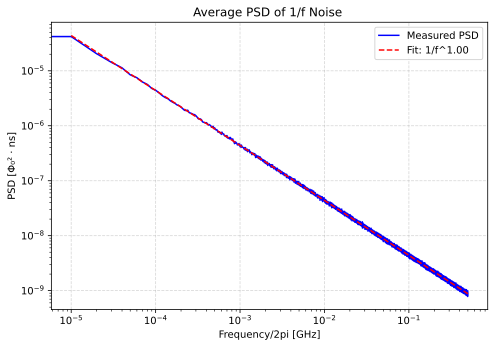

Sanity Checks (1/f noise):
PSD fit: power = -1.0004, intercept = -9.5797, R² = 0.9990, S0 = 1.622423e-05 Φ₀


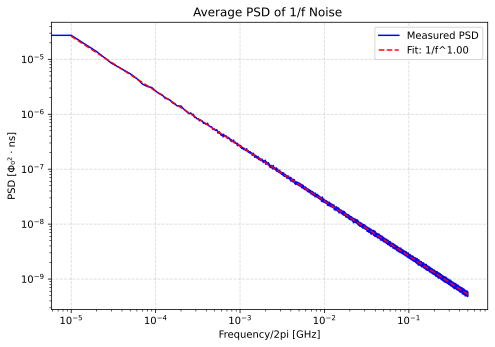

Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -9.8772, R² = 0.9990, S0 = 1.151808e-05 Φ₀


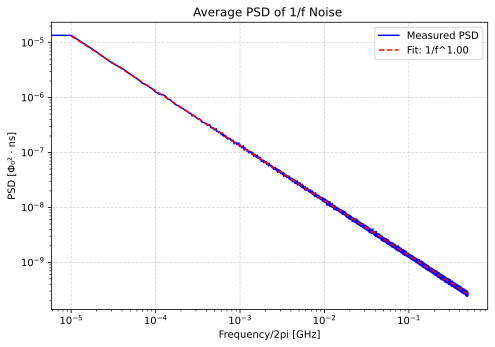

Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -10.3341, R² = 0.9990, S0 = 6.807006e-06 Φ₀


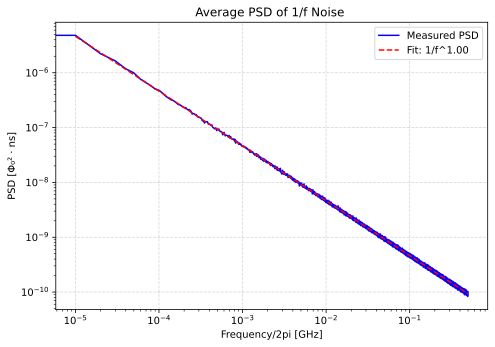

Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -11.3579, R² = 0.9990, S0 = 2.094393e-06 Φ₀


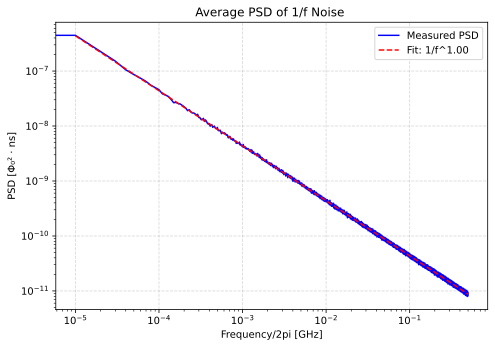

In [2]:
# ...existing code...

# Sweep S0 from 10e-5 to 2e-5 and store results
S0_values = np.linspace(10e-5, 1e-5, 5)
populations = []
real_S0s = []

for S0 in S0_values:
    pop, real_S0 = analyze_noise_trajectory(S0)
    populations.append(pop)
    real_S0s.append(real_S0)

populations = np.array(populations)
real_S0s = np.array(real_S0s)

# Save results using qutip's qsave in the same file
data_dict = {
    'populations': populations,
    'real_S0s': real_S0s,
    'S0_values': S0_values
}
qt.qsave(data_dict, 'simulation_results')

In [2]:
# Load the saved simulation results
loaded_data = qt.qload('simulation_results')
populations = loaded_data['populations']
real_S0s = loaded_data['real_S0s']
S0_values = loaded_data['S0_values']


In [3]:
def analyze_and_plot_t2(result, S0):
    """
    Analyze T2 decay from simulation results and compare with theoretical estimate.
    
    Parameters:
    result: array of simulation results
    S0: noise strength parameter
    """
    from scipy.optimize import curve_fit
    
    # Setup time points
    t_max = 50000
    N = t_max
    time_points = np.linspace(0, t_max, N)
    
    # Define exponential decay function with fixed offset of 1/2
    def exp_decay_fixed_offset(t, T):
        return 0.5 * (1 + np.exp(-t / T))
    
    
    # Fit the data with exponential decay (fixed offset = 1/2)
    params, pcov = curve_fit(exp_decay_fixed_offset, time_points, result, p0=[1000])
    T_fit = params[0]
    
    # Plot the results with the fit
    plt.figure(figsize=(5, 3))
    plt.plot(time_points, result, 'b-', label='Simulation data')
    plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
             label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
    plt.xlabel('Time (ns)')
    plt.ylabel('Population')
    plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the fitted parameters
    print(f"Fitted T = {T_fit:.4f} ns")
    
    # Calculate theoretical estimate
    # Note: You'll need to access sc from the global scope or pass it as parameter
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    
    # Setup Hamiltonian for optimal frequency calculation
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
    rate = ((S0P**2 / 0.021) * (0.22629367)**2 * 2)
    estimated_time = 1 / rate
    print(rate/2)
    print(f"Estimated T = {estimated_time:.4f} ns")
    analytical_T2 = 1/(2*S0P**2/0.1/4)
    
    return T_fit, estimated_time, analytical_T2

In [4]:
real_S0s

array([2.09403584e-05, 1.62242336e-05, 1.15180752e-05, 6.80700567e-06,
       2.09439274e-06])

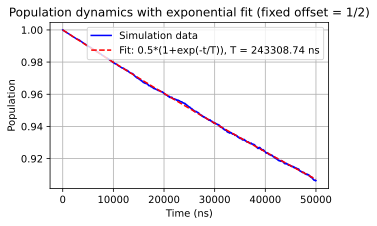

Fitted T = 243308.7383 ns
2.1099744507214065e-06
Estimated T = 236969.6940 ns


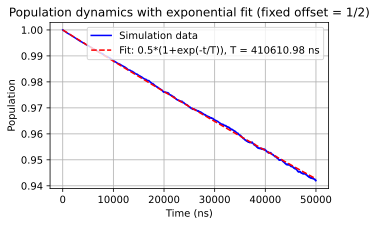

Fitted T = 410610.9765 ns
1.266593801498024e-06
Estimated T = 394759.5507 ns


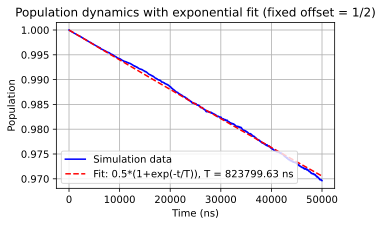

Fitted T = 823799.6323 ns
6.383646008128767e-07
Estimated T = 783251.4512 ns


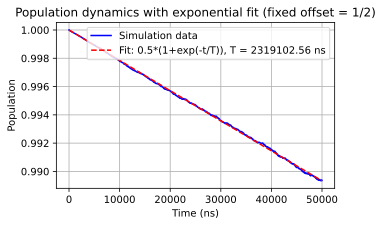

Fitted T = 2319102.5595 ns
2.229570456018401e-07
Estimated T = 2242584.4344 ns


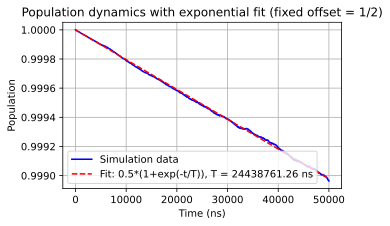

Fitted T = 24438761.2646 ns
2.110693755727742e-08
Estimated T = 23688893.6940 ns


In [5]:
# Analyze T2 for all populations and collect results
T_fits = []
estimated_times = []
analytical_T2s = []

for i in range(len(populations)):
    T_fit, estimated_time, analytical_T2 = analyze_and_plot_t2(populations[i], real_S0s[i])
    T_fits.append(T_fit)
    estimated_times.append(estimated_time)
    analytical_T2s.append(analytical_T2)

T_fits = np.array(T_fits)
estimated_times = np.array(estimated_times)
analytical_T2s = np.array(analytical_T2s)


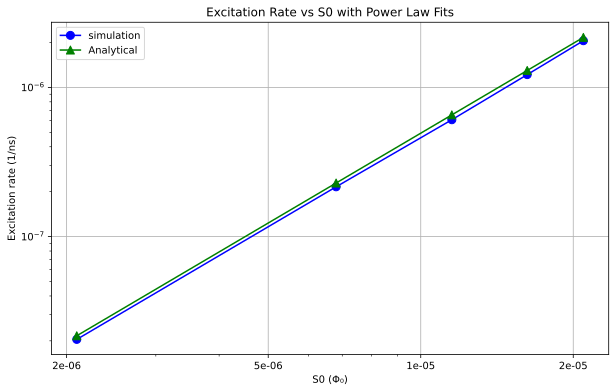

Fitted data power law:  2.03
Analytical data power law:  2.00


In [55]:
from scipy.optimize import curve_fit

# Plot excitation rate vs real_S0s and fit power law
plt.figure(figsize=(10, 6))
plt.loglog(real_S0s, 1/T_fits/2, 'bo-', label='simulation', markersize=8)
plt.loglog(real_S0s, 1/analytical_T2s/2, 'g^-', label='Analytical', markersize=8)

# Fit power law to the fitted data

def power_law(x, a, b):
    return a * x**b

# Fit the fitted excitation rates
popt_fitted, pcov_fitted = curve_fit(power_law, real_S0s, 1/T_fits/2)
a_fitted, b_fitted = popt_fitted

# Fit the analytical excitation rates
popt_analytical, pcov_analytical = curve_fit(power_law, real_S0s, 1/analytical_T2s/2)
a_analytical, b_analytical = popt_analytical

# Add power law fit lines to the plot
x_fit = np.logspace(np.log10(real_S0s.min()), np.log10(real_S0s.max()), 100)

plt.xlabel('S0 (Φ₀)')
plt.ylabel('Excitation rate (1/ns)')
plt.title('Excitation Rate vs S0 with Power Law Fits')

# Add more x-axis tick marks
x_ticks = [2e-6, 5e-6, 1e-5, 2e-5]
plt.xticks(x_ticks, [f'{x:.0e}' for x in x_ticks])

plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted data power law:  {b_fitted:.2f}")
print(f"Analytical data power law:  {b_analytical:.2f}")


Running simulation for A = 0.006283
Sanity Checks (1/f noise):
PSD fit: power = -1.0001, intercept = -9.9602, R² = 0.9990, S0 = 1.046859e-05 Φ₀


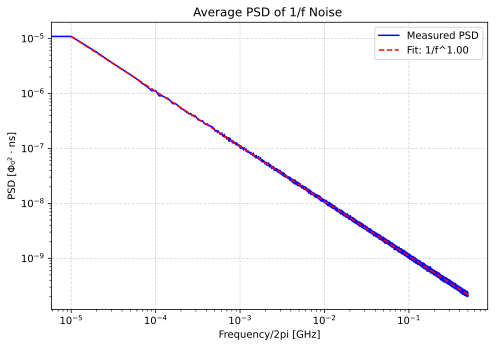

Running simulation for A = 0.012566
Sanity Checks (1/f noise):
PSD fit: power = -1.0001, intercept = -9.9601, R² = 0.9990, S0 = 1.047027e-05 Φ₀


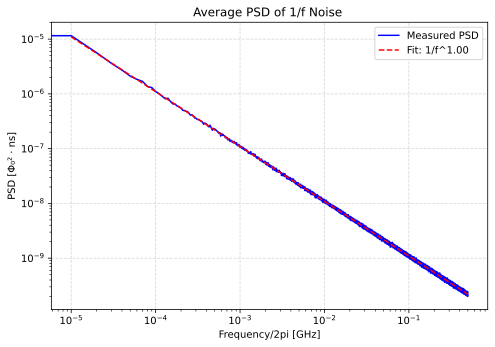

Running simulation for A = 0.018850
Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -9.9601, R² = 0.9990, S0 = 1.047043e-05 Φ₀


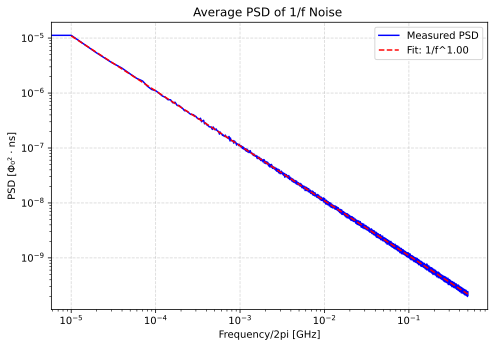

Running simulation for A = 0.025133
Sanity Checks (1/f noise):
PSD fit: power = -1.0002, intercept = -9.9602, R² = 0.9990, S0 = 1.046882e-05 Φ₀


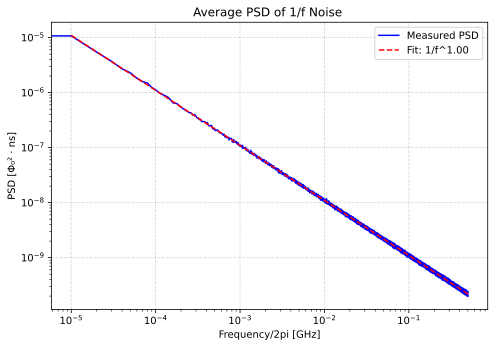

Running simulation for A = 0.031416
Sanity Checks (1/f noise):
PSD fit: power = -1.0002, intercept = -9.9603, R² = 0.9990, S0 = 1.046792e-05 Φ₀


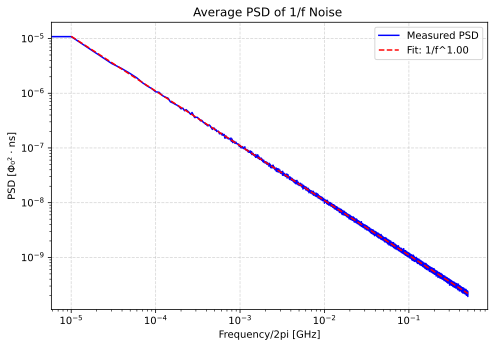

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed

def run_simulation(A):
    # System parameters
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    S0 = 5e-5
    # Setup Hamiltonian for optimal frequency calculation
    sc_temp = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    optimal_omega = sc_temp.optimal_omegad(A)[0]*2*np.pi

    # Setup actual system
    sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)

    # Setup noise matrix
    noise_matrix = sc.noise.copy()
    first_element = noise_matrix[0, 0]
    for i in range(noise_matrix.shape[0]):
        noise_matrix[i, i] -= first_element
    noise = qt.Qobj(noise_matrix)

    # Noise generation parameters
    sample_rate = 1
    tnoise_max = int(1e5)
    relative_PSD_strength = S0**2
    num_realizations = 1000
    ifwhite = False

    # Generate noise trajectories
    N = tnoise_max * sample_rate
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()
    real_S0 = gn.analyze_noise_psd(trajs)

    # Setup Floquet system
    _, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    U_init, _, _ = state_and_sigmax(0)
    init_state = U_init[:,0]
    initial_state = qt.Qobj(init_state)

    # Setup rotating frame Hamiltonian
    H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
    evals_rot, U = np.linalg.eigh(H0_rot)
    evals_rot, U = sort_eigenpairs(evals_rot, U)
    Ud = U.T.conj()
    dressed0 = qt.Qobj(U[:,0])
    dressed1 = qt.Qobj(U[:,1])
    P0 = dressed0 * dressed0.dag()
    P1 = dressed1 * dressed1.dag()

    # Simulation parameters
    t_max = 50000
    N = t_max
    time_points = np.linspace(0, t_max, N)

    def simulate_trajectory(i):
        # Create Hamiltonian with noise trajectory
        traj = np.cos(phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [qt.Qobj(H0_rot), [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Simulation options
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-8}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        
        dim = noise.shape[0]
        avg_values = np.zeros((dim + 2, len(time_points)))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[2, j] = qt.expect(P0, state_t)
            avg_values[3, j] = qt.expect(P1, state_t)
        
        return avg_values

    # Run parallel simulations
    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))
    result = np.array(result)

    # Calculate average expectation values
    avg_expect_values = np.mean(result, axis=0)

    return avg_expect_values[2]

# Define A values
A_values = np.linspace(1e-3*2*np.pi, 5e-3*2*np.pi, 5)
# Store results in arrays
A_results = []
population_results = []

# Run simulations for each A value
for A_val in A_values:
    print(f"Running simulation for A = {A_val:.6f}")
    population_result = run_simulation(A_val)
    A_results.append(A_val)
    population_results.append(population_result)

# Convert to numpy arrays for easier handling
A_results = np.array(A_results)
population_results = np.array(population_results)

# Store in dictionary for saving
rate_A_results = {
    'A_values': A_results,
    'populations': population_results
}

# Save results
qt.qsave(rate_A_results, 'rate_A')


In [4]:
# Load the saved rate_A_results
loaded_rate_A = qt.qload('rate_A')
rate_A_results = loaded_rate_A

A_values = rate_A_results['A_values']
populations = rate_A_results['populations']

In [5]:
S0 = 1.047043e-05

In [20]:
def analyze_and_plot_t2(result,  A):
    """
    Analyze T2 decay from simulation results and compare with theoretical estimate.
    
    Parameters:
    result: array of simulation results
    S0: noise strength parameter
    """
    from scipy.optimize import curve_fit
    
    # Setup time points
    t_max = 50000
    N = t_max
    time_points = np.linspace(0, t_max, N)
    
    # Define exponential decay function with fixed offset of 1/2
    def exp_decay_fixed_offset(t, T):
        return 0.5 * (1 + np.exp(-t / T))
    
    
    # Fit the data with exponential decay (fixed offset = 1/2)
    params, pcov = curve_fit(exp_decay_fixed_offset, time_points, result, p0=[1000])
    T_fit = params[0]
    
    # Plot the results with the fit
    plt.figure(figsize=(5, 3))
    plt.plot(time_points, result, 'b-', label='Simulation data')
    plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
             label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
    plt.xlabel('Time (ns)')
    plt.ylabel('Population')
    plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the fitted parameters
    print(f"Fitted T = {T_fit:.4f} ns")
    
    # Calculate theoretical estimate
    # Note: You'll need to access sc from the global scope or pass it as parameter
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    
    # Setup Hamiltonian for optimal frequency calculation
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
    sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)
    # Setup rotating frame Hamiltonian
    H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
    evals_rot, U = np.linalg.eigh(H0_rot)
    evals_rot, U = sort_eigenpairs(evals_rot, U)
    Ud = U.T.conj()
    me = (Ud@np.array([[0,0],[0,1]])@U)[0,1]
    detu = (evals_rot[1]-evals_rot[0])/2/np.pi
    rate = S0P**2 / (detu) * (np.abs(me))**2 * 2
    estimated_time = 1 / rate
    print(f"Estimated T = {estimated_time:.4f} ns")
    analytical_T2 = 1/(2*S0P**2/0.1/4)
    print(f"Analytical T2 = {analytical_T2:.4f} ns")
    
    return T_fit, estimated_time, analytical_T2

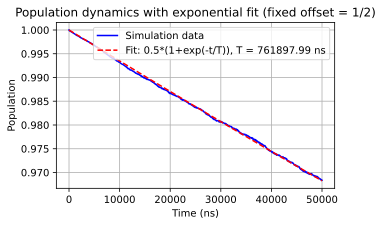

Fitted T = 761897.9905 ns
Estimated T = -761165.2406 ns
Analytical T2 = 924522.5042 ns


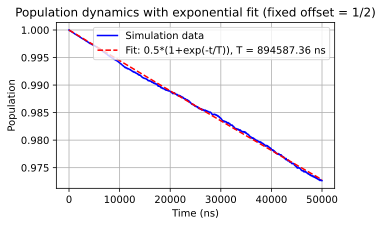

Fitted T = 894587.3645 ns
Estimated T = -873467.5044 ns
Analytical T2 = 924522.5042 ns


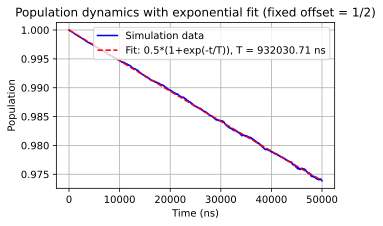

Fitted T = 932030.7108 ns
Estimated T = -919761.1073 ns
Analytical T2 = 924522.5042 ns


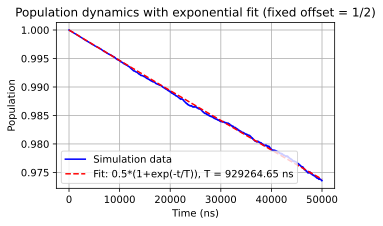

Fitted T = 929264.6548 ns
Estimated T = -948069.1086 ns
Analytical T2 = 924522.5042 ns


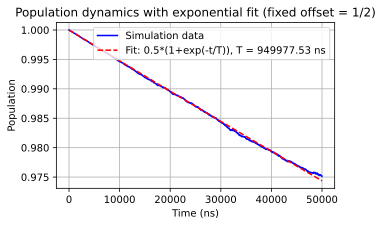

Fitted T = 949977.5337 ns
Estimated T = -971494.3837 ns
Analytical T2 = 924522.5042 ns


In [21]:
# Analyze T2 for all A-dependent populations and collect results
T_fits_A = []
estimated_times_A = []
analytical_T2s_A = []

# Use a fixed S0 value for all A simulations (from cell 7)
S0_fixed = 3.819488e-05

for i in range(len(populations)):
    T_fit, estimated_time, analytical_T2 = analyze_and_plot_t2(populations[i], A_values[i])
    T_fits_A.append(T_fit)
    estimated_times_A.append(estimated_time)
    analytical_T2s_A.append(analytical_T2)

T_fits_A = np.array(T_fits_A)
estimated_times_A = np.array(estimated_times_A)
analytical_T2s_A = np.array(analytical_T2s_A)

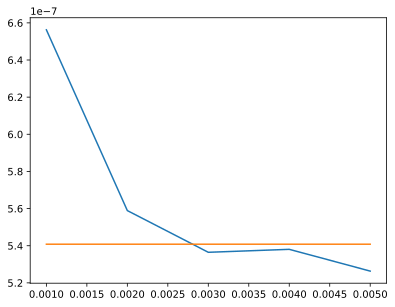

In [22]:
plt.plot(A_values/2/np.pi, 1/T_fits_A/2)
plt.plot(A_values/2/np.pi, 1/analytical_T2s_A/2)